# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_cluster"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Jun13-1726'

In [4]:
state_key = 'cluster'
batch_key = 'batch'
state_type = 'cluster'
leiden_key='leiden'
batch_type = 'batch_specific_features'
distribution = 'normal'
n_cells = [200,100,100,50,30]
n_genes = [100,100,50,30,20]
state_dispersion = [5.0,4.0,4.0,3.0,2.0]

In [5]:
from concord.utils.simulation import (
    SimConfig, ClusterConfig, BatchConfig, Simulation
)

seed = 42                     # or whatever you used earlier

# ───────────────────────────────────── SimConfig ──
sim_cfg = SimConfig(
    n_cells=[200, 100, 100, 50, 30],   # one entry per cluster
    n_genes=[100, 100, 50, 30, 20],    # one entry per cluster
    seed=seed,
    non_neg=True,
    to_int=True,
)

# ─────────────────────────────────── ClusterConfig ──
state_cfg = ClusterConfig(
    n_states=5,
    distribution="normal",
    level=5.0,                # state_level
    min_level=0.0,            # state_min_level
    dispersion=[5.0, 4.0, 4.0, 3.0, 2.0],
    program_structure="uniform",
    program_on_time_fraction=0.3,
    global_non_specific_gene_fraction=0.10,
    pairwise_non_specific_gene_fraction={
        (0, 1): 0.7,
        (2, 3): 0.4,
        # all other pairs → 0.0, so omit them for brevity
    },
)

# ──────────────────────────────────── BatchConfig ──
batch_cfg = BatchConfig(
    n_batches=2,
    effect_type="batch_specific_features",
    distribution="normal",
    level=[5, 5],
    dispersion=[3.0, 3.0],
    feature_frac=0.15,            # batch_feature_frac
    cell_proportion=[0.1, 0.9],  # proportion of cells in each batch
)

# ─────────────────────────────────── Simulation ──
sim = Simulation(sim_cfg, state_cfg, batch_cfg)

adata, adata_state = sim.simulate_data()
adata.layers["counts"] = adata.X.copy()

In [6]:
adata.obs_names

Index(['batch_1_Cell_30', 'batch_1_Cell_33', 'batch_1_Cell_38',
       'batch_1_Cell_39', 'batch_1_Cell_42', 'batch_1_Cell_43',
       'batch_1_Cell_58', 'batch_1_Cell_79', 'batch_1_Cell_84',
       'batch_1_Cell_89',
       ...
       'batch_2_Cell_470', 'batch_2_Cell_471', 'batch_2_Cell_472',
       'batch_2_Cell_473', 'batch_2_Cell_474', 'batch_2_Cell_475',
       'batch_2_Cell_476', 'batch_2_Cell_478', 'batch_2_Cell_479',
       'batch_2_Cell_480'],
      dtype='object', length=480)

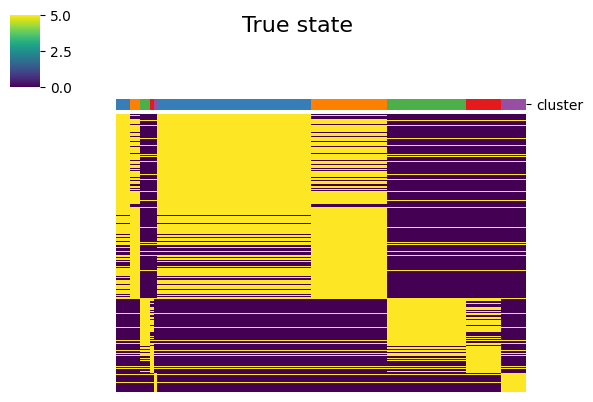

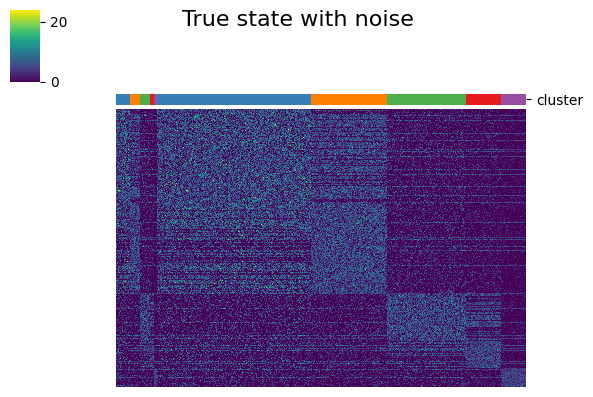

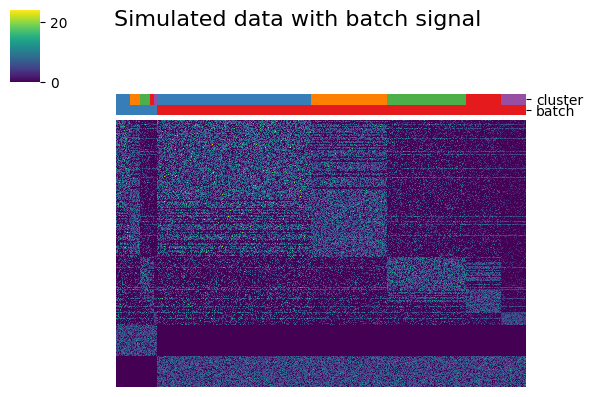

In [7]:
ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)

### No batch effect, no noise

In [33]:
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='PCA_no_noise', n_pc=30, random_state=seed)
ccd.ul.run_umap(adata_state, source_key='PCA_no_noise', result_key='UMAP_no_noise', random_state=seed)

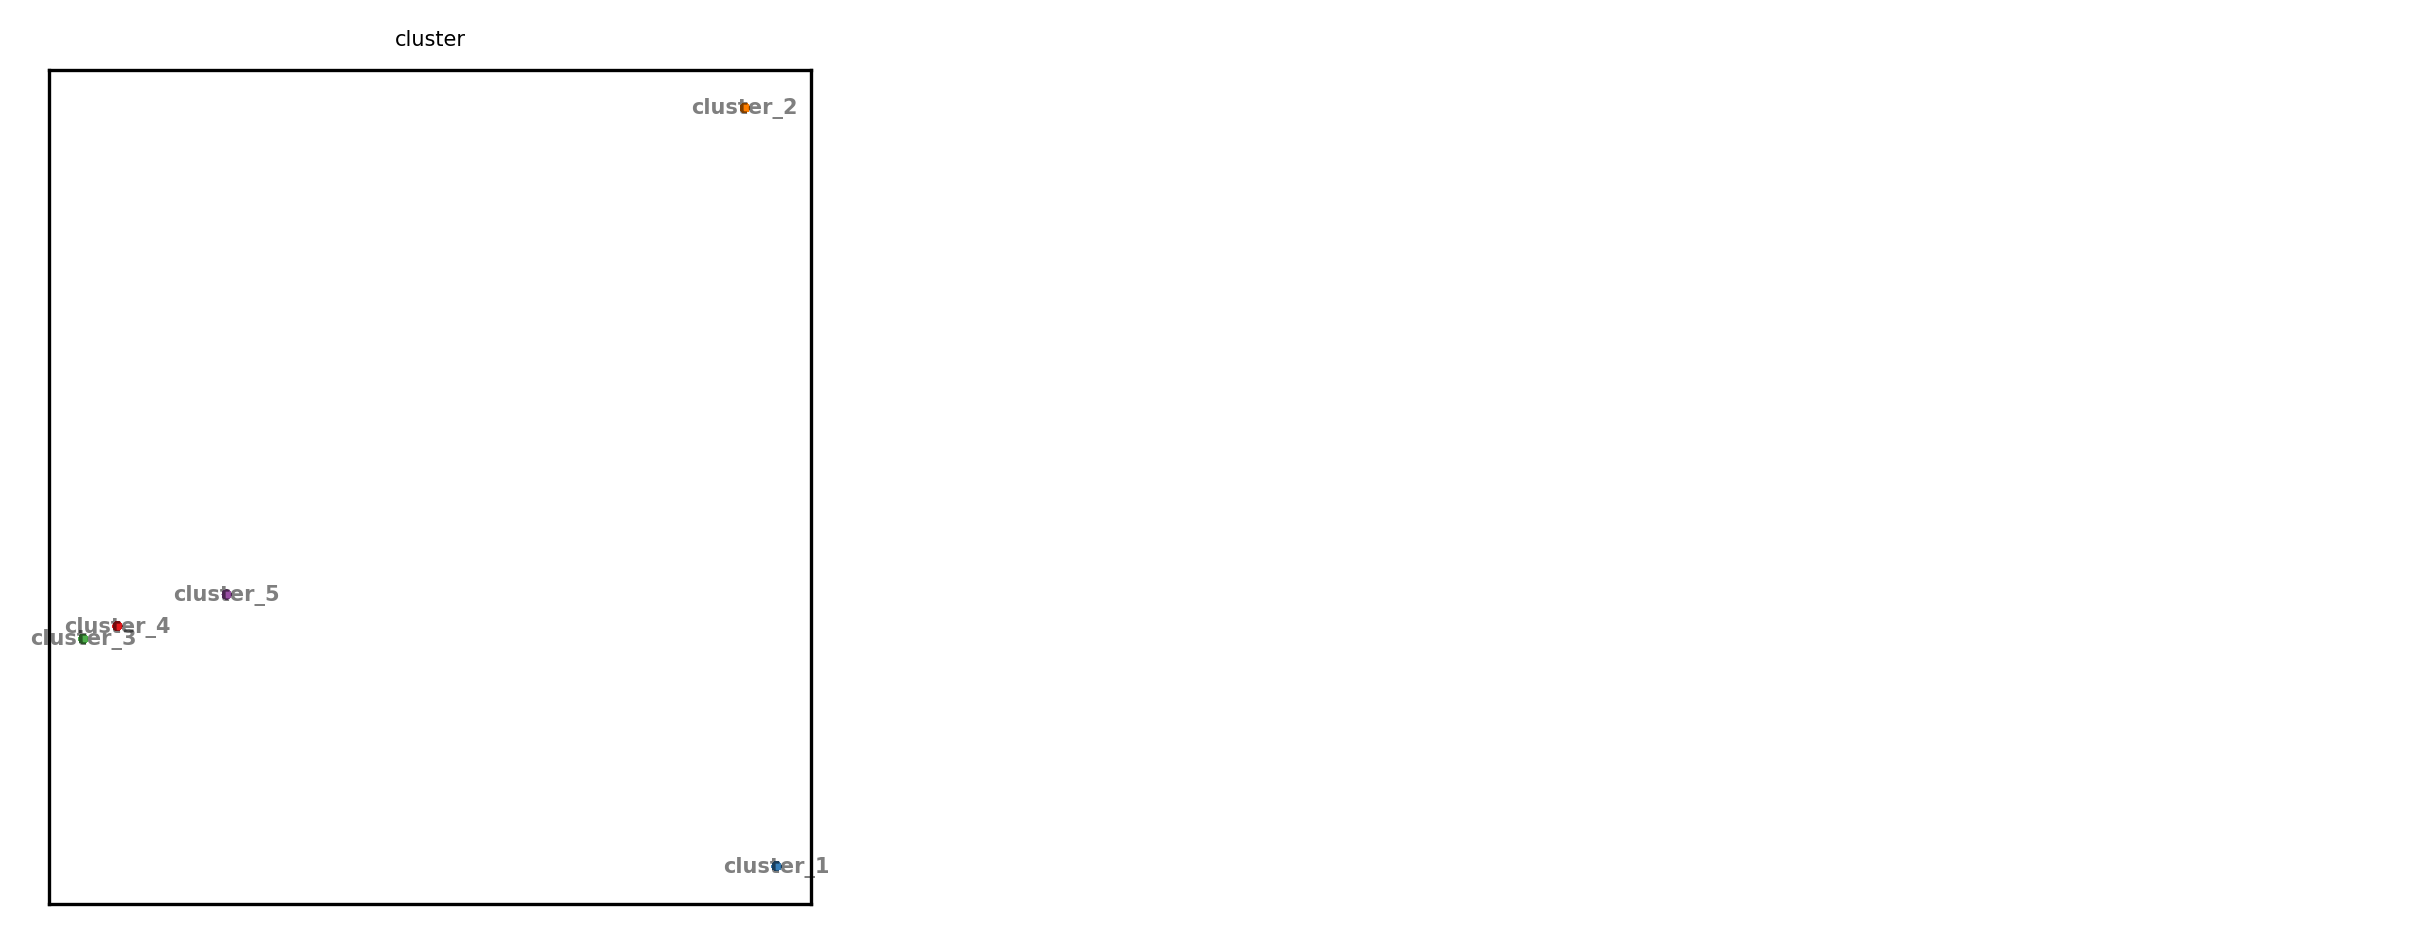

In [34]:
show_basis = 'PCA_no_noise'
show_cols = [state_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

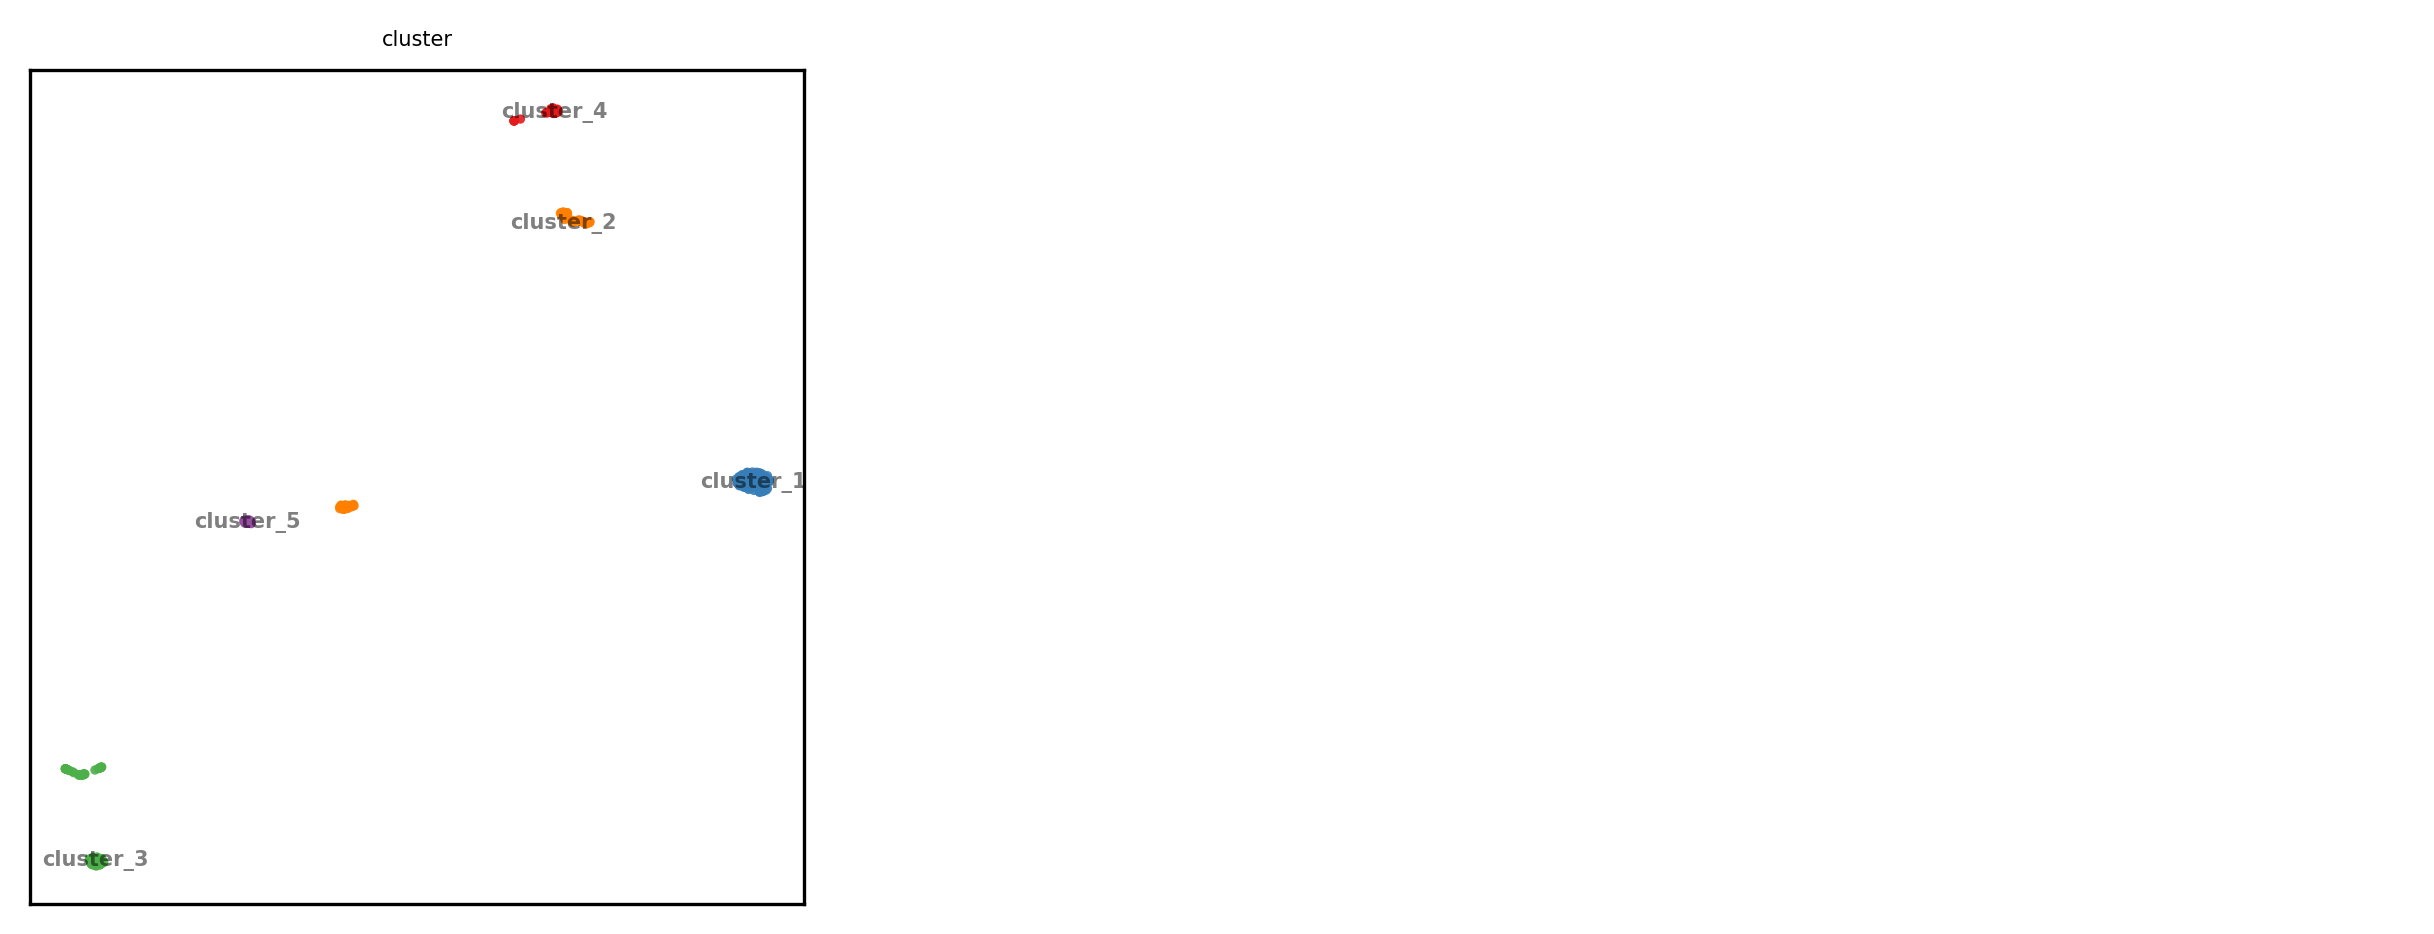

In [35]:
show_basis = 'UMAP_no_noise'
show_cols = [state_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

### NO batch effect, noise added, PCA and UMAP

In [36]:
adata_state.X = adata_state.layers['wt_noise'].copy()
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='PCA_wt_noise', n_pc=30, random_state=seed)
ccd.ul.run_umap(adata_state, source_key='PCA_wt_noise', result_key='UMAP_wt_noise', random_state=seed)

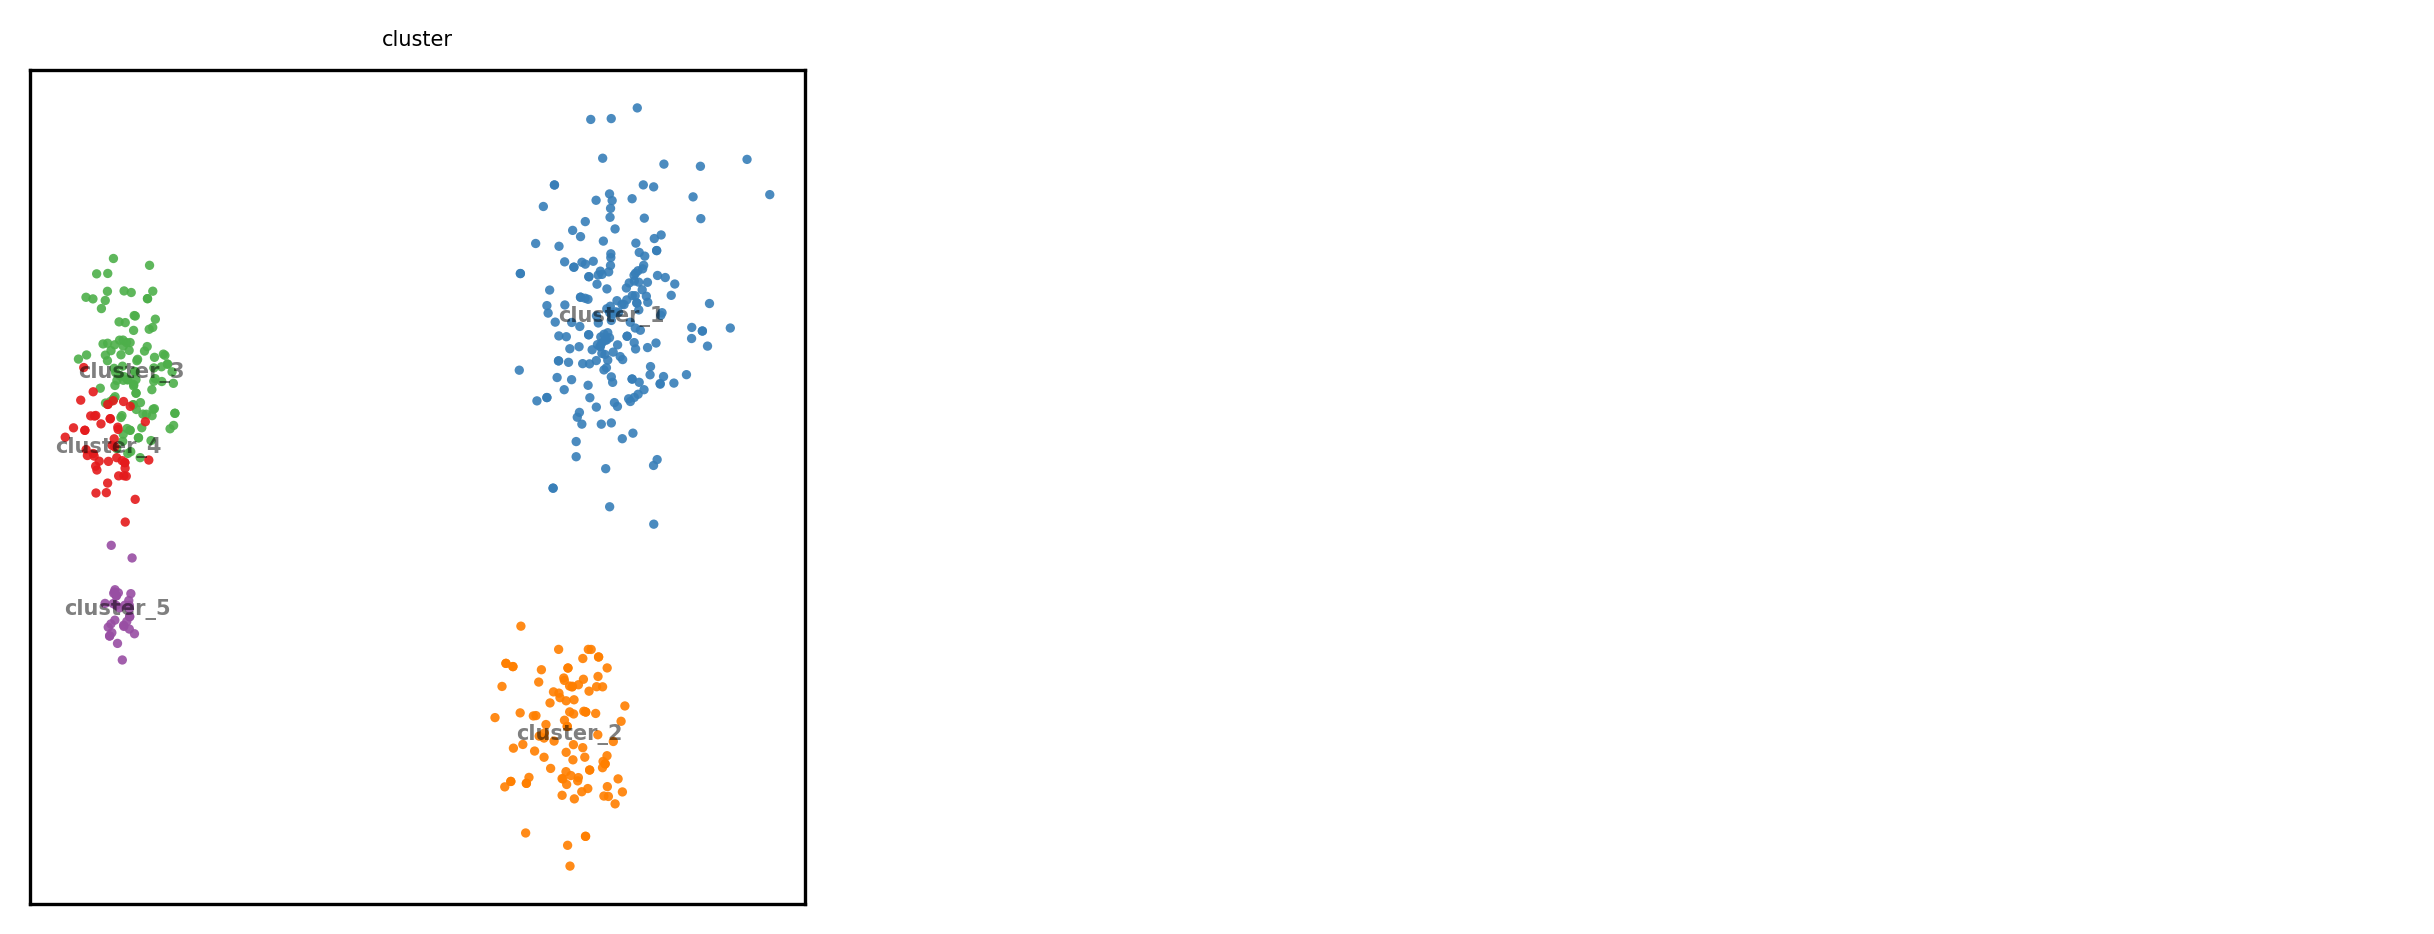

In [37]:
show_basis = 'PCA_wt_noise'
show_cols = [state_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

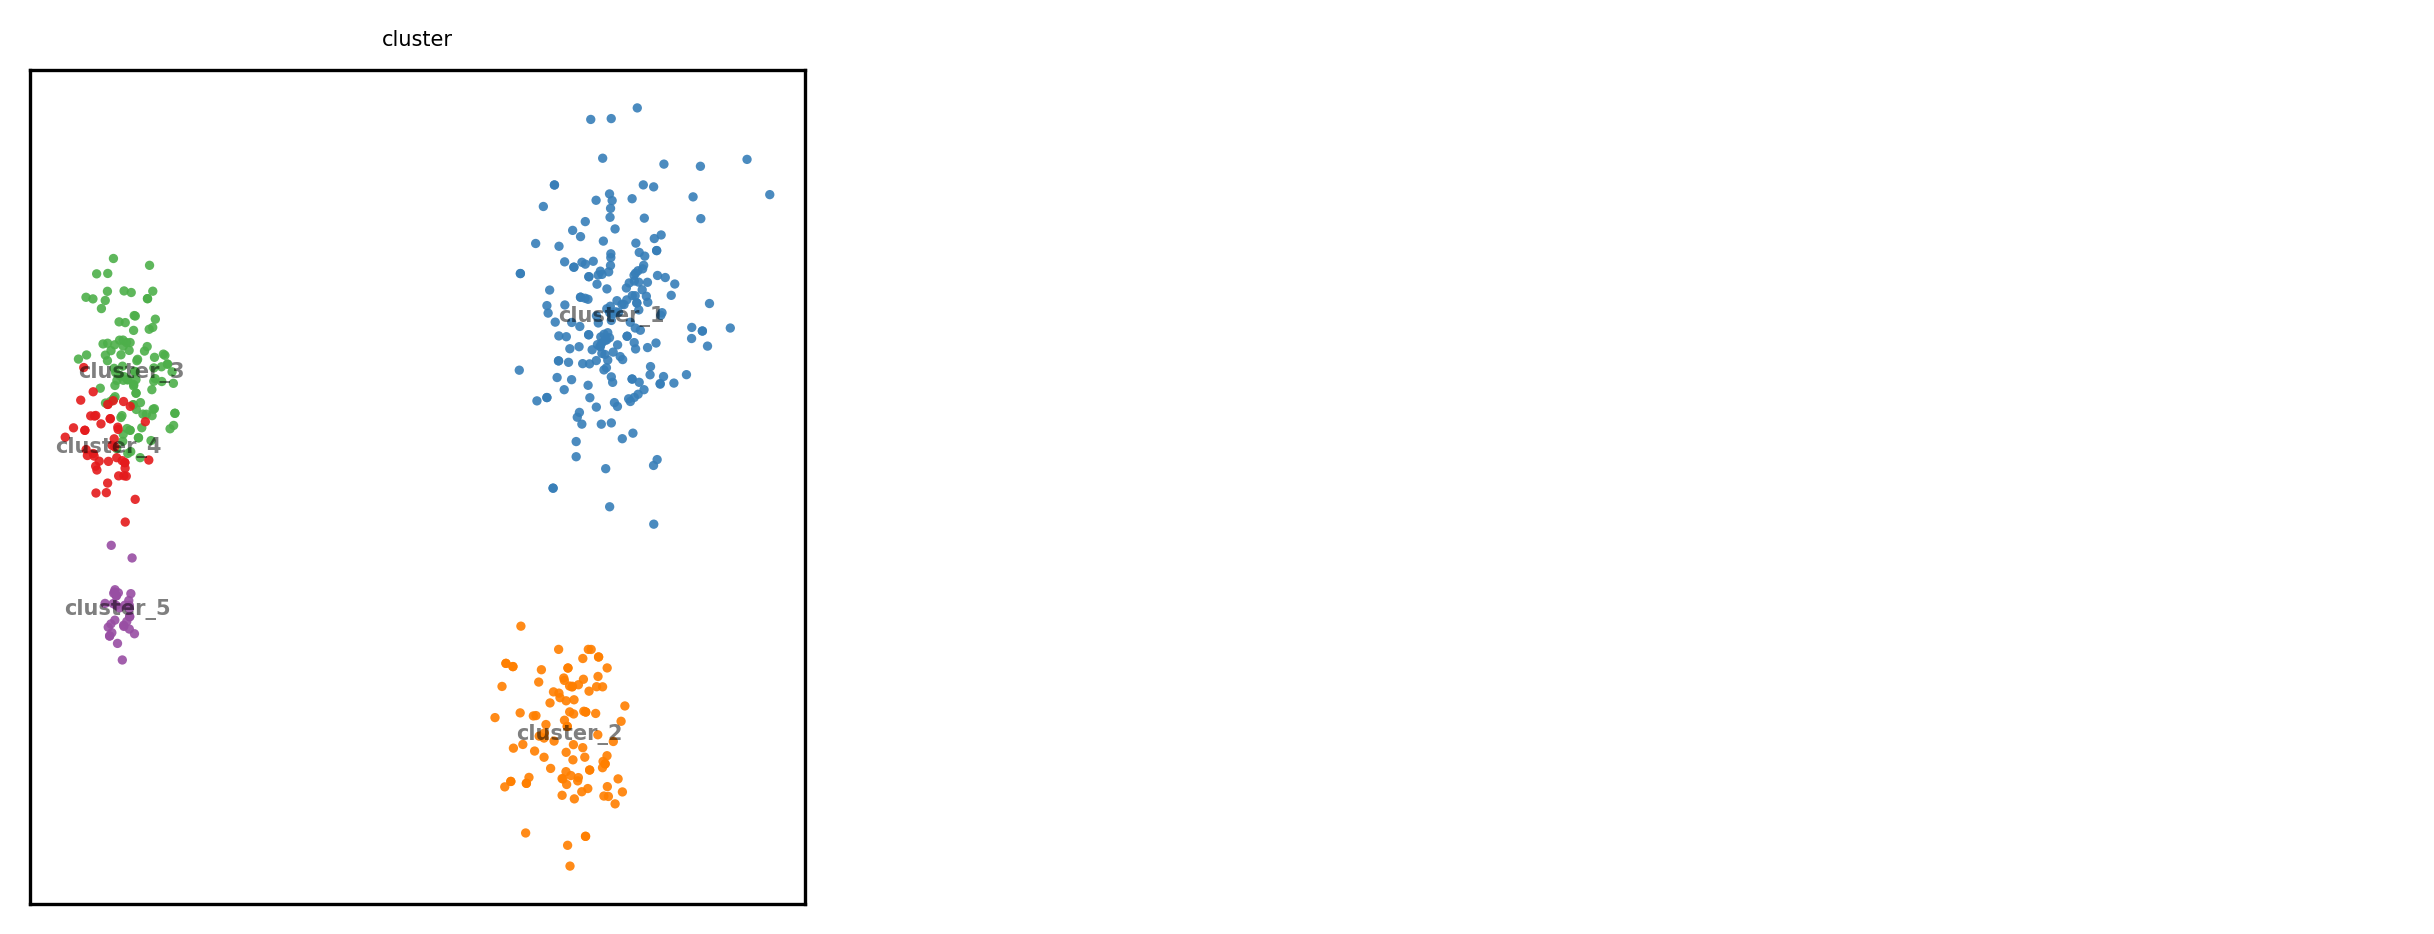

In [38]:
show_key = 'UMAP_wt_noise'
show_cols = [state_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

### No batch correction, PCA and UMAP

In [39]:
n_pcs = min(adata.n_obs, adata.n_vars)-1
sc.pp.pca(adata, n_comps=n_pcs)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs)
sc.tl.umap(adata, min_dist=0.5)
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

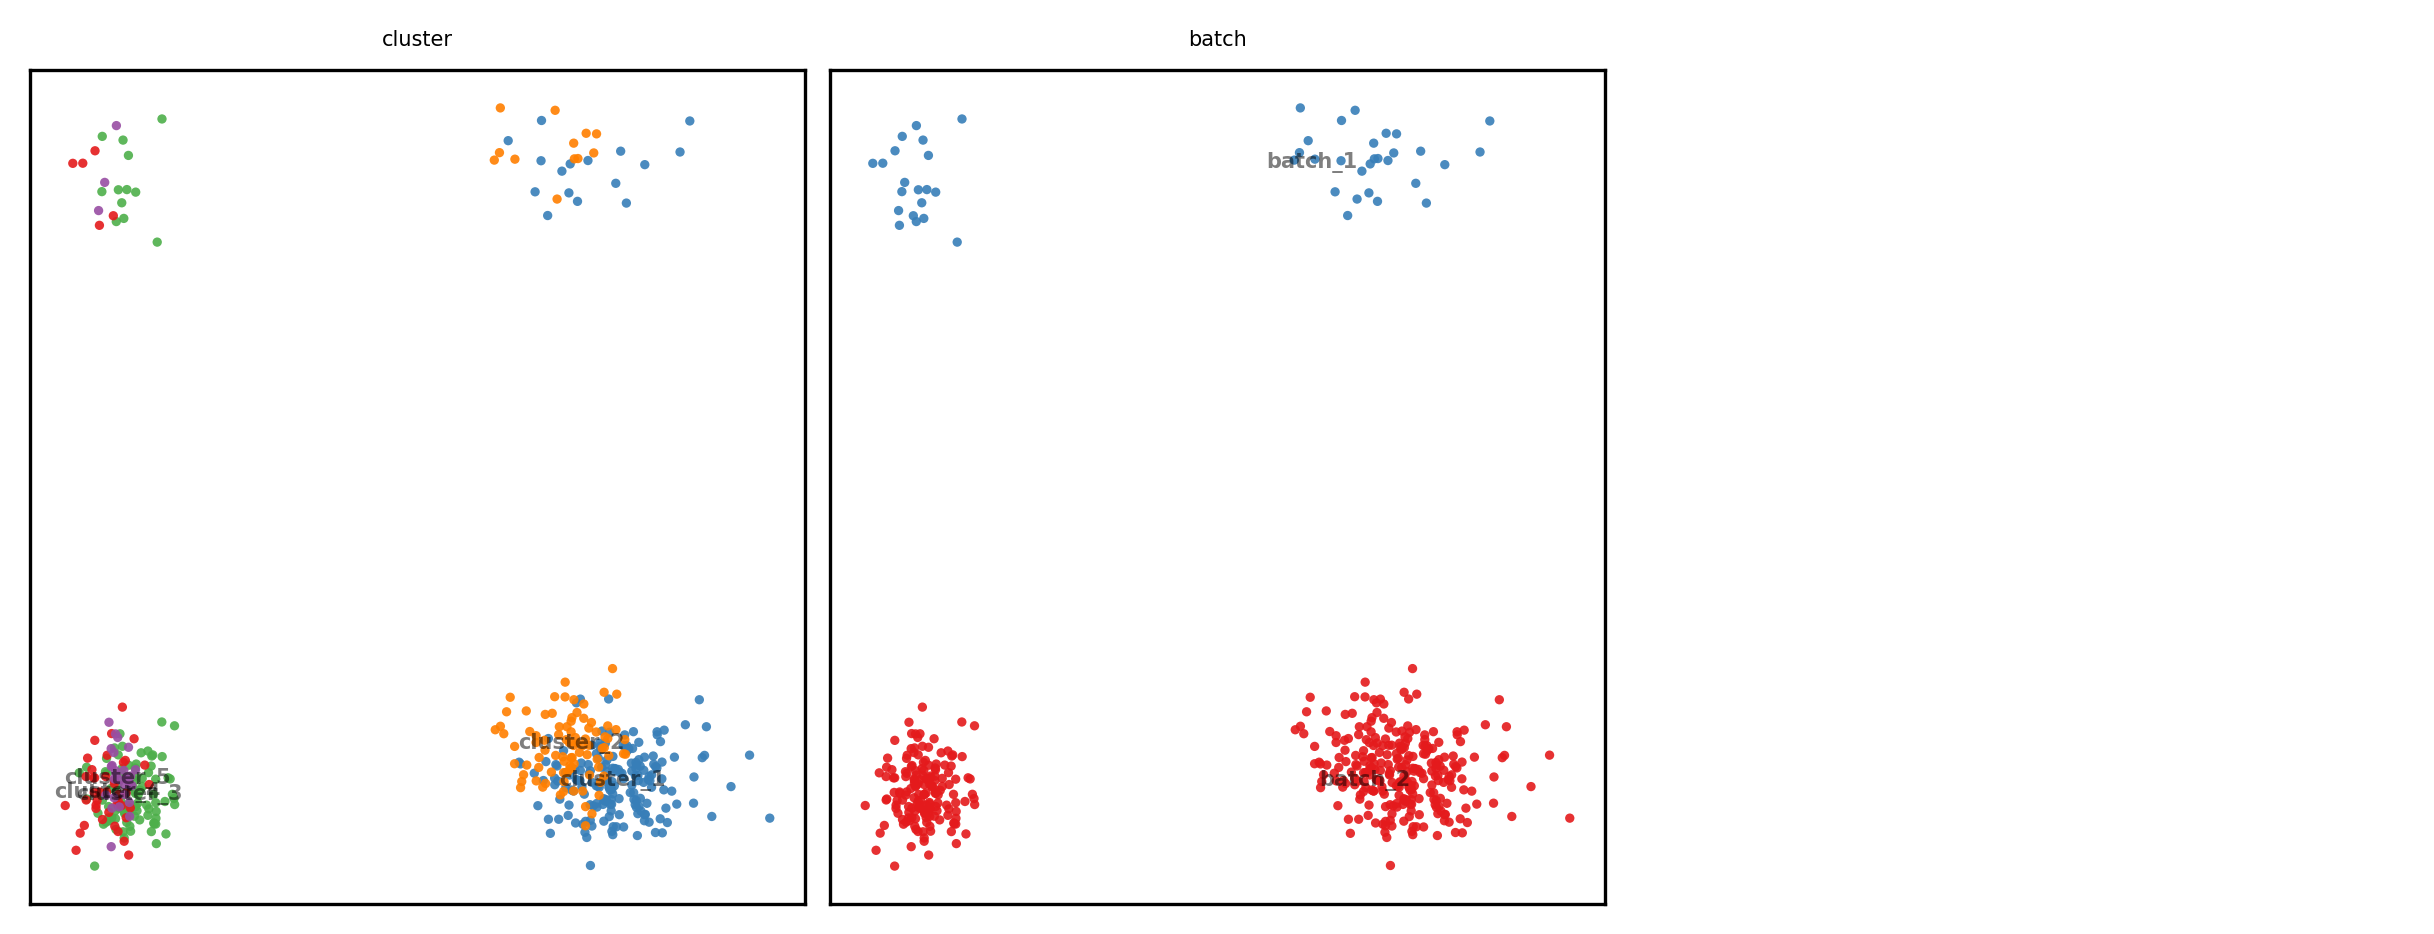

In [40]:
show_basis = 'X_pca'
show_cols = [state_key, batch_key]

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"wtbatch_{show_basis}_{file_suffix}.png"
)

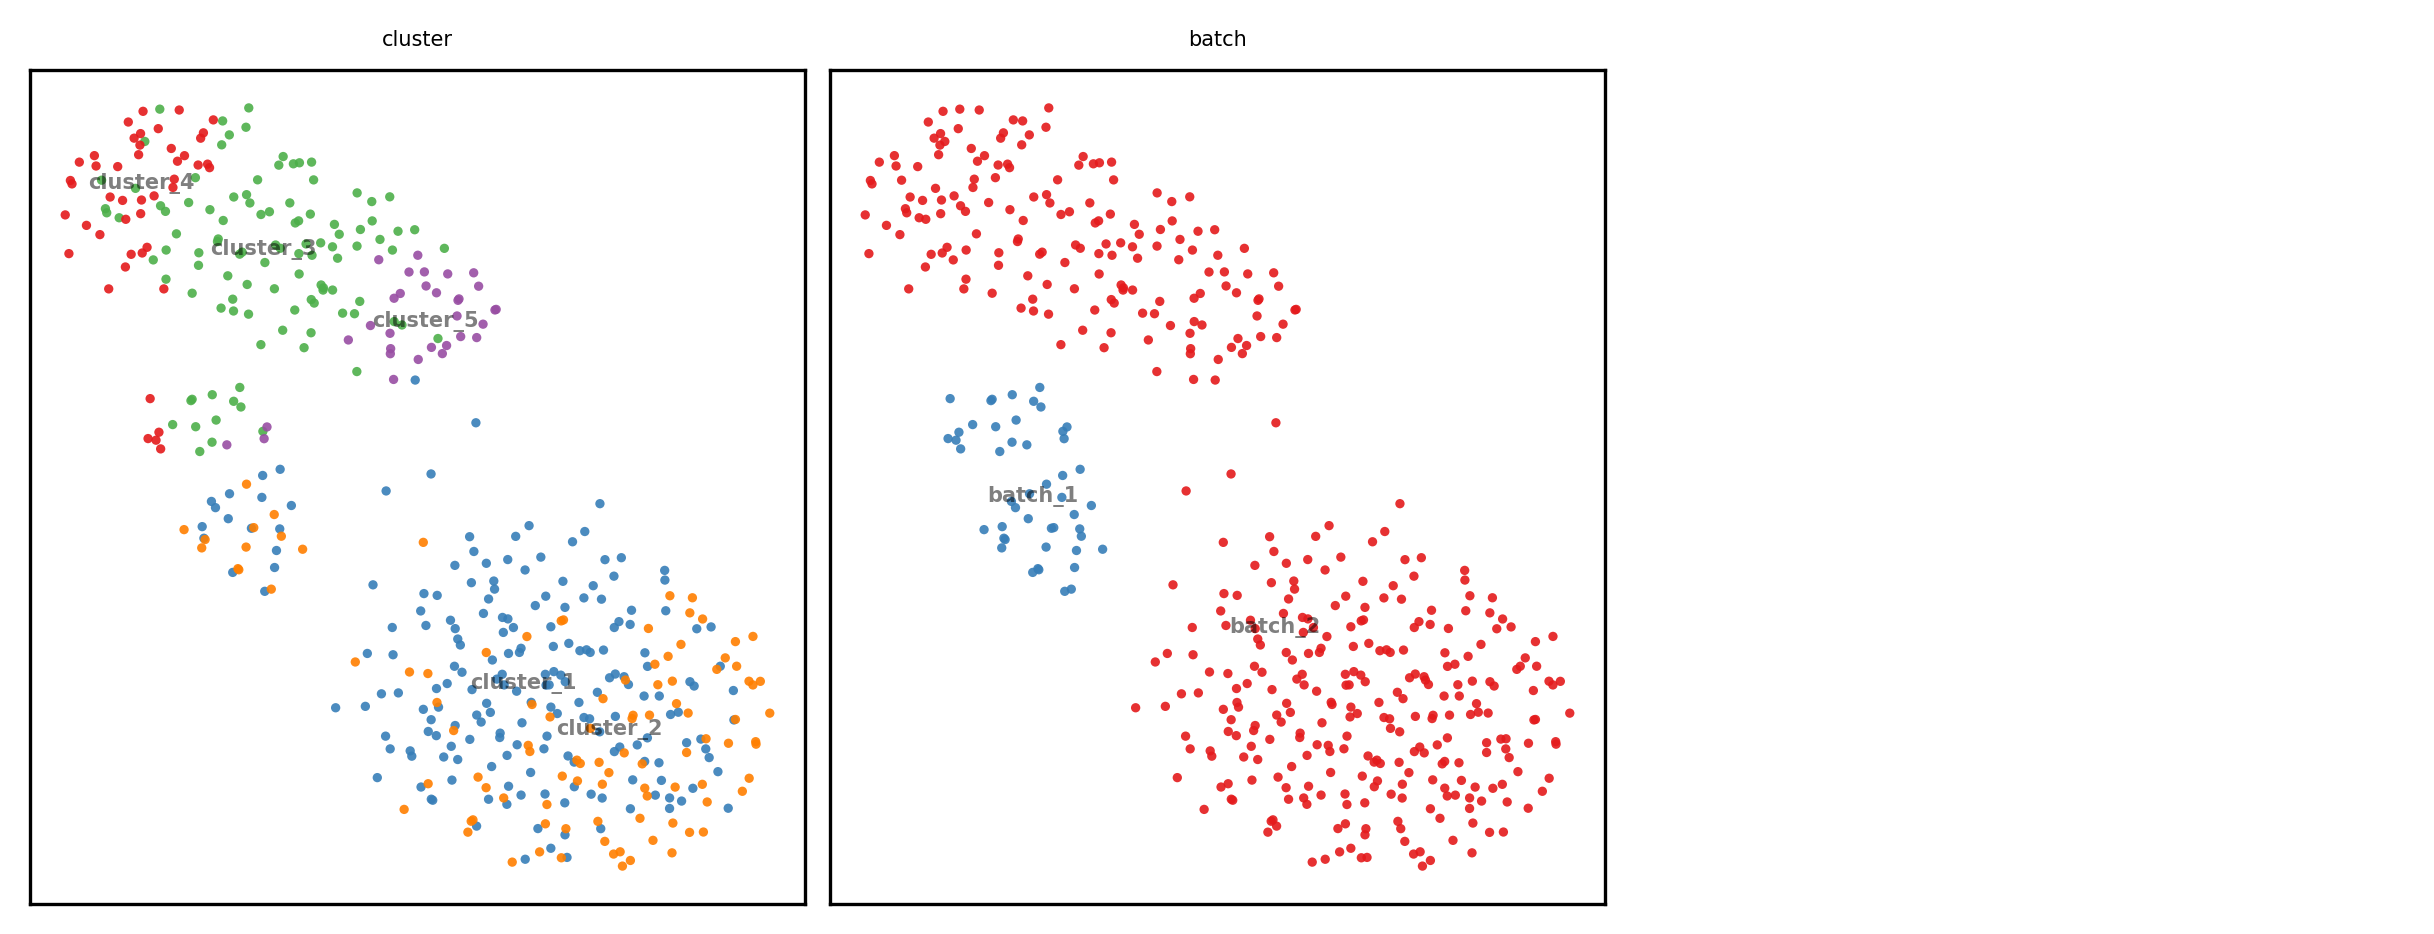

In [41]:
show_basis = 'X_umap'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"wtbatch_{show_basis}_{file_suffix}.png"
)

### Concord

In [8]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=32,
                      n_epochs=10,
                      lr=1e-2,
                      train_frac=1.0,
                      schedule_ratio = 0.97,
                      latent_dim=32, # latent dimension
                      encoder_dims = [64], # encoder architecture
                      decoder_dims = [64], # decoder architecture
                      norm_type = 'layer_norm',
                      use_importance_mask=False,
                      #importance_penalty_weight=1.0,
                      use_decoder=False,
                      domain_embedding_dim=8,
                      domain_key=batch_key, # key indicating batch
                      augmentation_mask_prob = 0.5, # augmentation mask probability, recommend between 0.1 and 0.7
                      clr_temperature = 0.5, # temperature for NT-Xent loss
                      seed=seed, # random seed
                      p_intra_domain = 1.0, # probability of intra-domain sampling
                      p_intra_knn=0.3,
                      use_faiss=False,
                      sampler_knn = adata.n_obs//10,
                      verbose=False, # print training progress
                      inplace=True, # whether to modify original adata, set to False if you want to keep all expressions
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


Epoch 9 Training: 100%|██████████| 14/14 [00:00<00:00, 719.38it/s, loss=3.06]


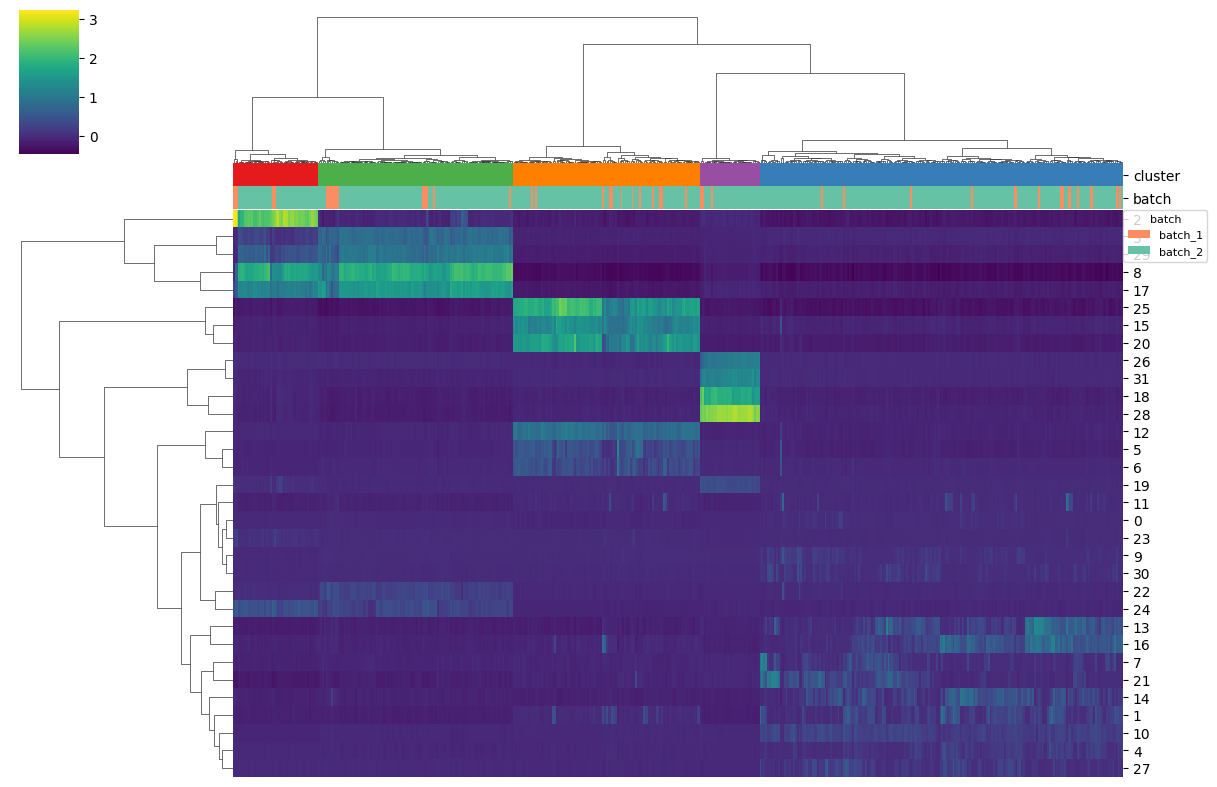

In [9]:
state_key = 'cluster'
ccd.pl.heatmap_with_annotations(adata, val='Concord', obs_keys=[state_key, batch_key], 
                                cluster_cols=True, cluster_rows=True, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'Concord_latent_heatmap_{file_suffix}.png')

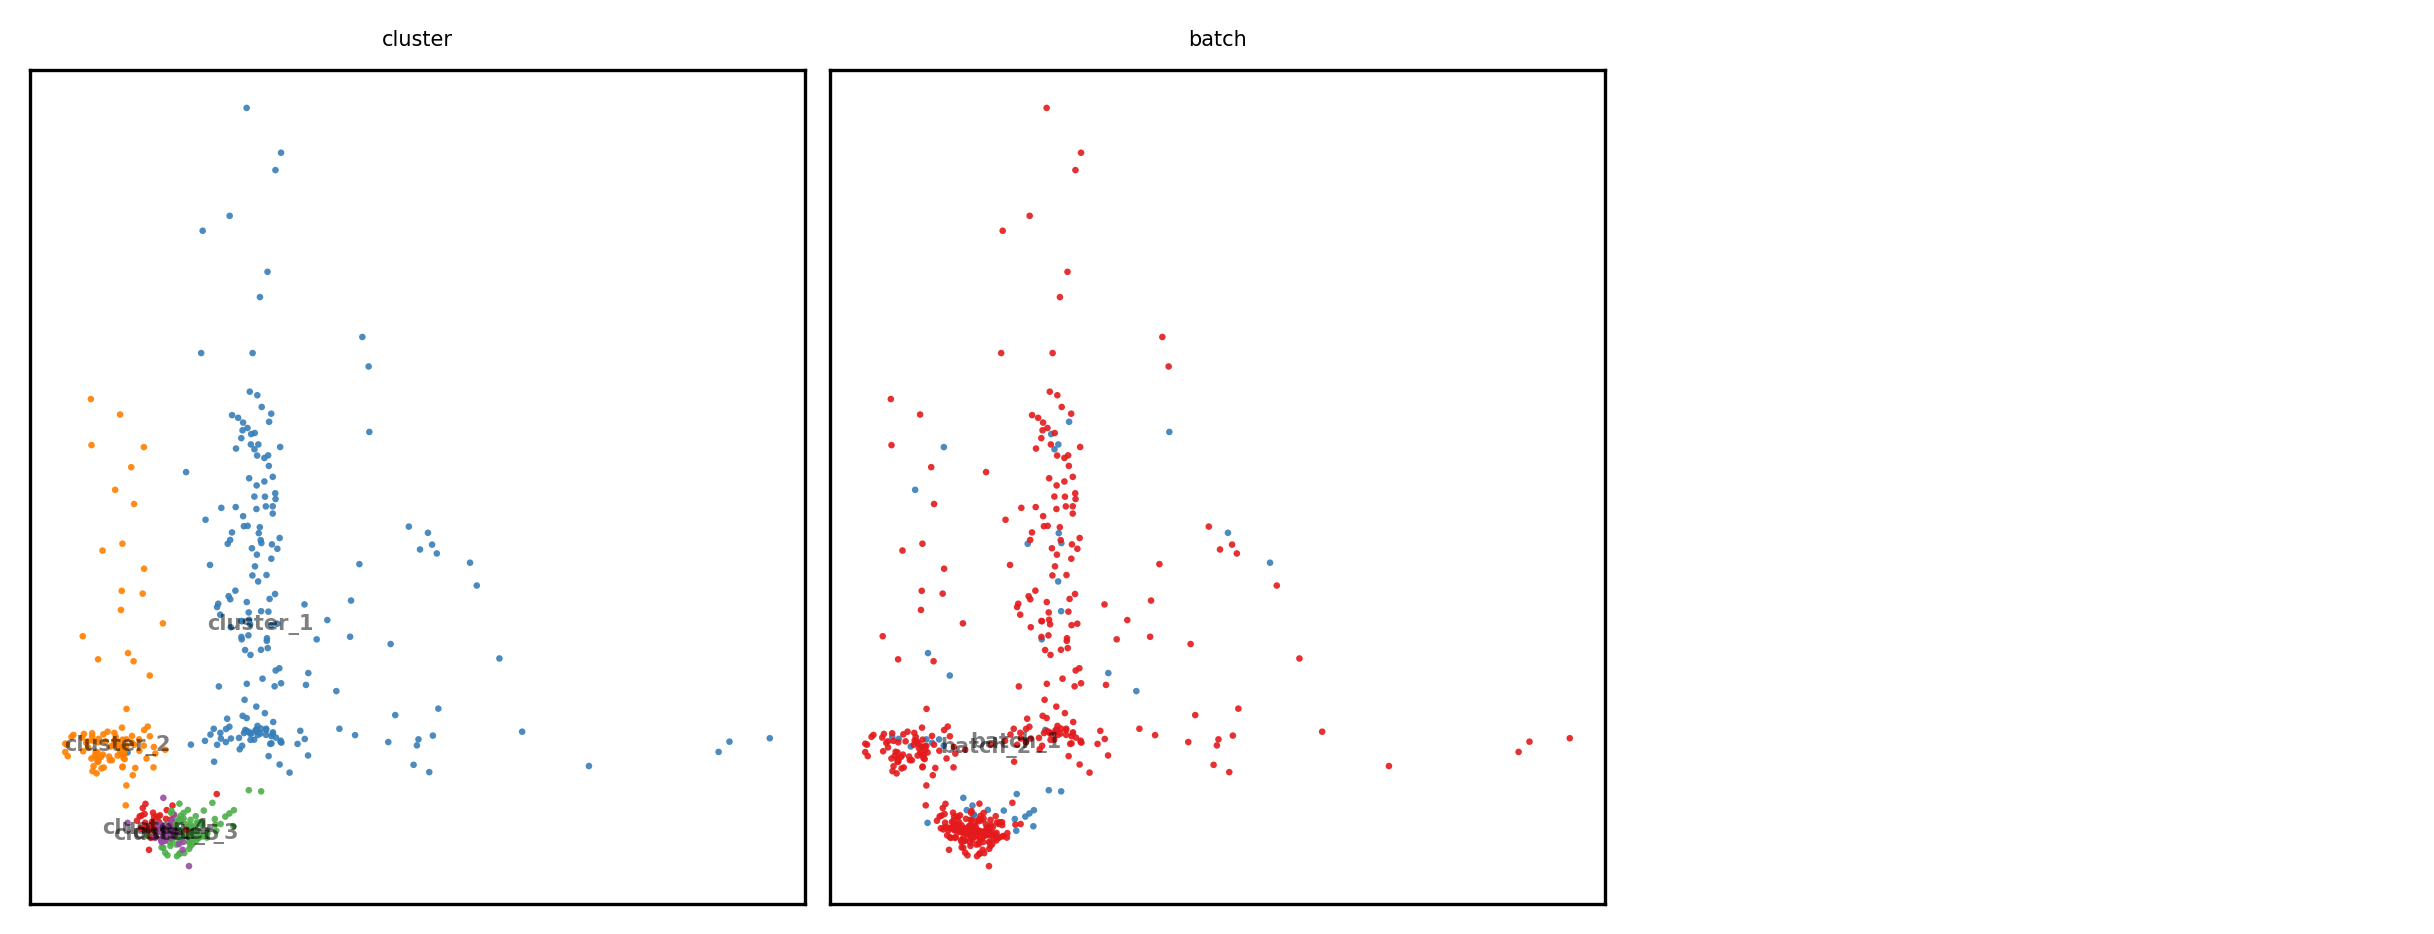

In [10]:
n_pc = min(adata.obsm[output_key].shape[1], adata.shape[0]) - 1
ccd.ul.run_pca(adata, source_key=output_key, result_key=f'{output_key}_PCA', n_pc=n_pc, random_state=seed)
show_basis = f'{output_key}'
show_cols = [state_key, batch_key]
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


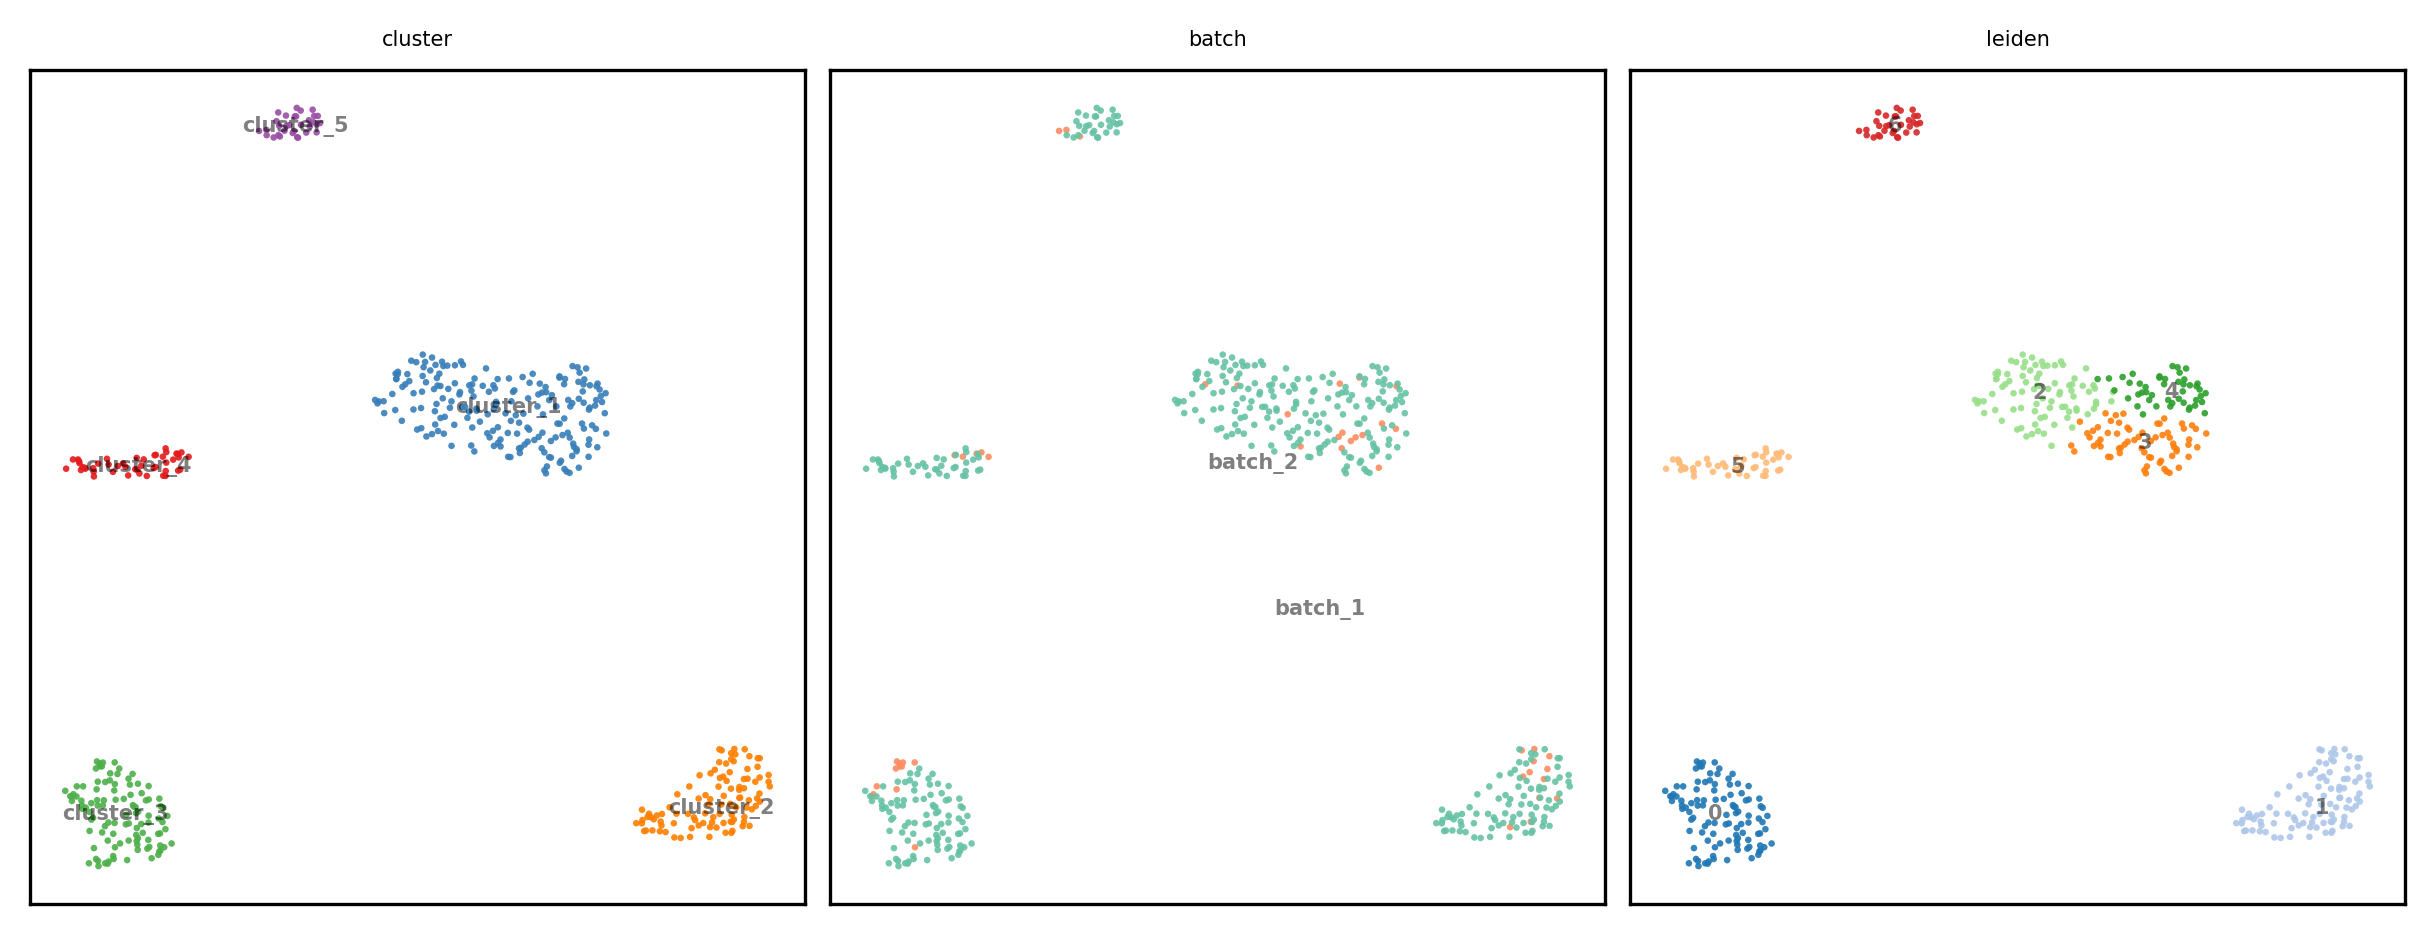

In [11]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep = 'Concord')
ccd.ul.run_umap(adata, source_key='Concord', result_key='Concord_UMAP_2D', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
sc.tl.leiden(adata, resolution=1.0)
show_cols = [state_key, batch_key, 'leiden']
show_basis = 'Concord_UMAP_2D'   
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    pal = {'cluster':'Set1', 'batch':'Set2', 'leiden':'tab20'},
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)


In [12]:
domain_coverage_scores = ccd.ul.calculate_domain_coverage_by_cluster(
    adata,
    domain_key='batch',  # The key for your experimental batches
    cluster_key='leiden', # The key for your cluster labels
    enrichment_threshold=.2 # Optional: adjust this threshold
)
domain_coverage_scores

{'batch_1': 1.0, 'batch_2': 1.0}

In [18]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      domain_key =batch_key, # key indicating batch
                      sampler_domain_minibatch_strategy='coverage',
                      domain_coverage=domain_coverage_scores,
                      verbose=False, # print training progress
                      inplace=True, # whether to modify original adata, set to False if you want to keep all expressions
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.


domain_minibatch_strategy: coverage
Number of batches per domain: {0: 1, 1: 1}


Epoch 9 Training: 100%|██████████| 2/2 [00:00<00:00, 184.04it/s, loss=3.69]


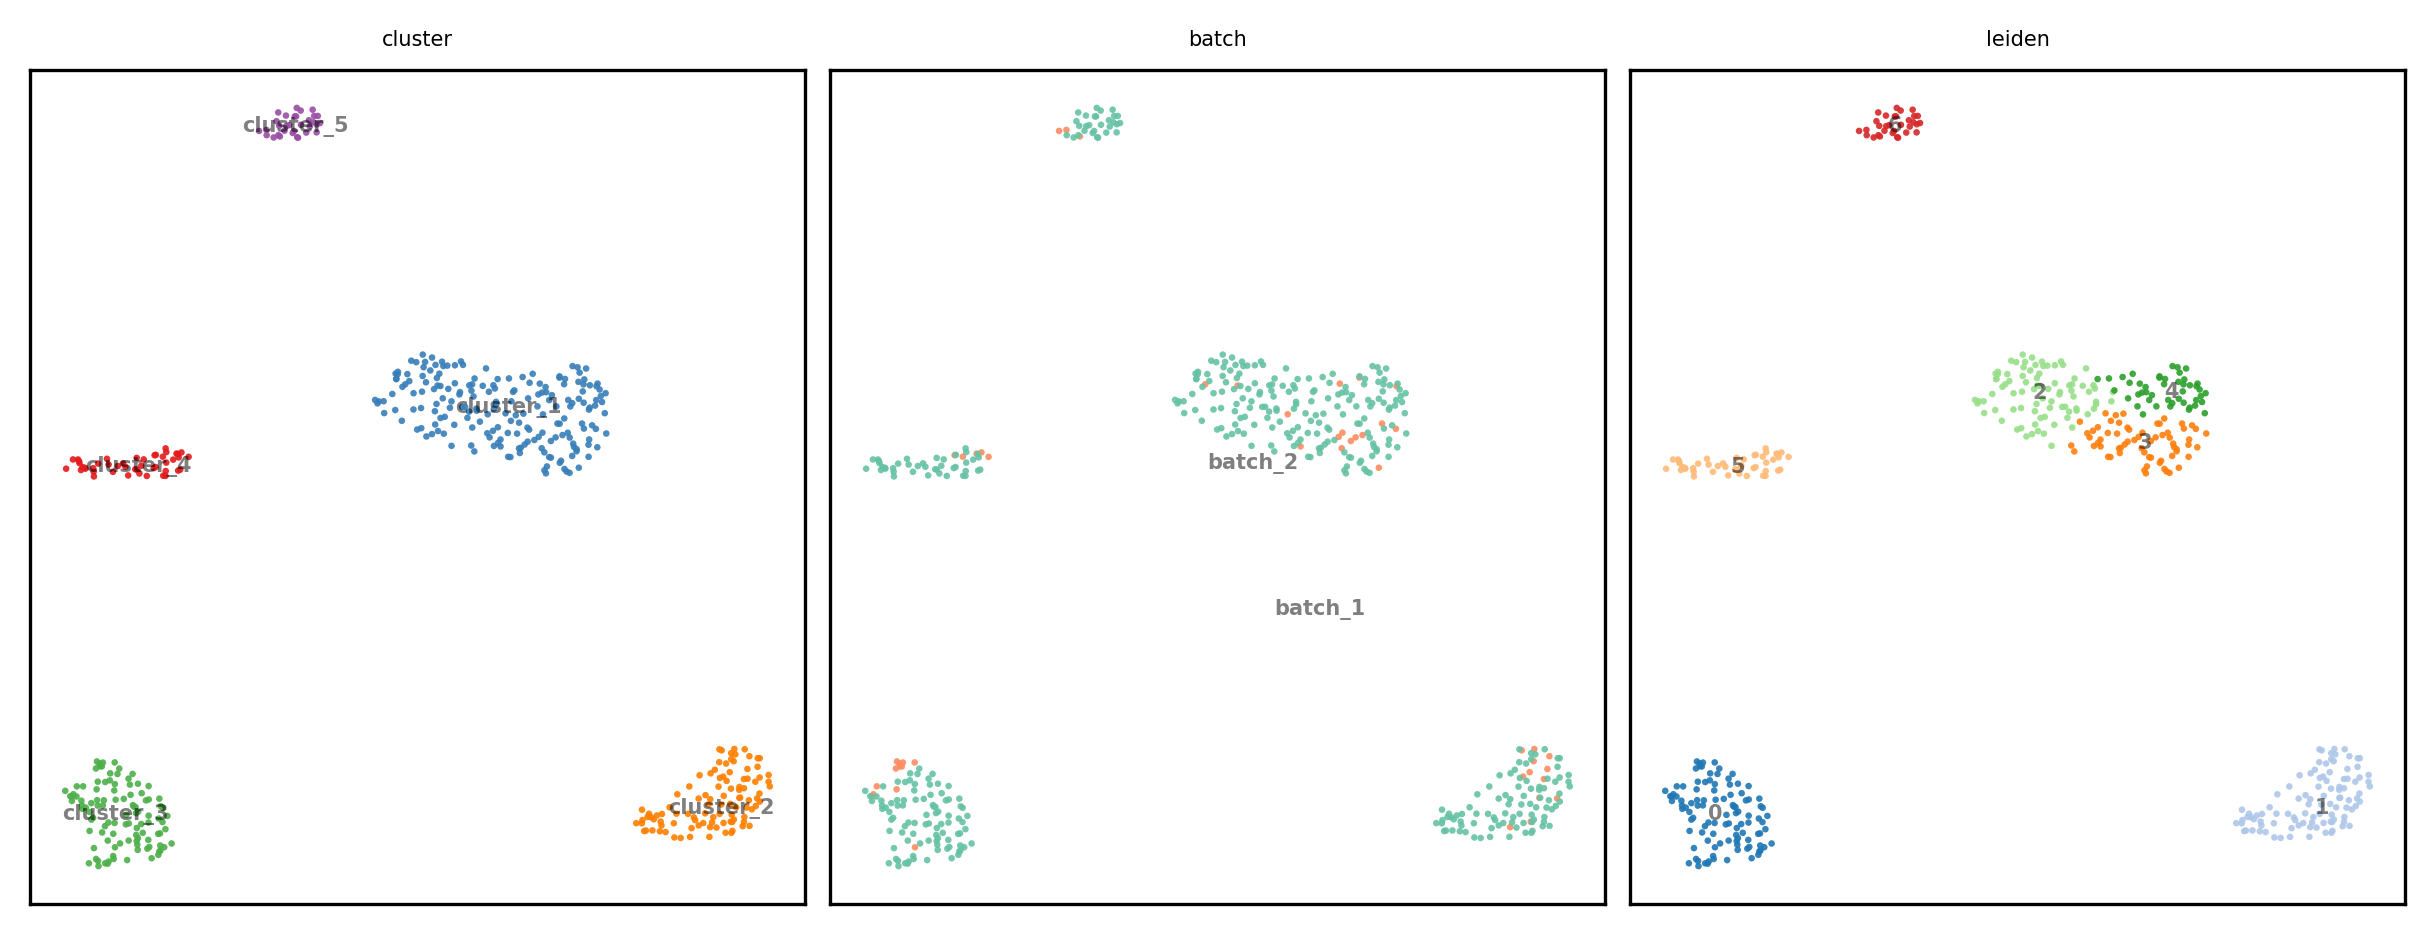

In [20]:
show_cols = [state_key, batch_key, 'leiden']
show_basis = 'Concord_UMAP_2D'   
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    pal = {'cluster':'Set1', 'batch':'Set2', 'leiden':'tab20'},
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)


In [47]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad") 
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad")

In [48]:
file_suffix

'Jun13-1704'

# Run other methods

In [49]:
file_suffix = f"{time.strftime('%b%d-%H%M')}"
ccd.set_verbose_mode(True)
show_cols = [state_key, batch_key]
timer = ccd.ul.Timer()
time_log = {}

### Scanorama

In [ ]:
output_key = 'Scanorama'

with timer:
    ccd.ul.run_scanorama(adata, batch_key="batch", output_key=output_key, return_corrected=True)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
# Plot heatmap of Scanorama corrected data
ccd.pl.heatmap_with_annotations(adata, val=f'{output_key}_corrected', obs_keys=[state_key, batch_key], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'{output_key}_corrected_heatmap_{file_suffix}.png')

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### Liger

In [ ]:
output_key = 'Liger'
adata.layers["counts"] = adata.X.copy()
with timer:
    ccd.ul.run_liger(adata, batch_key="batch", count_layer="counts", output_key=output_key, k=30, return_corrected=True)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
# Plot heatmap of Scanorama corrected data
ccd.pl.heatmap_with_annotations(adata, val=f'{output_key}_corrected', obs_keys=[state_key, batch_key], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'{output_key}_corrected_heatmap_{file_suffix}.png')

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### Harmony

In [ ]:
output_key = 'Harmony'
with timer:
    ccd.ul.run_harmony(adata, batch_key="batch", input_key='X_pca', output_key=output_key)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### scVI

In [ ]:
output_key = 'scVI'
transform_batch = 'batch_1'
with timer:
    scvi_vae = ccd.ul.run_scvi(adata, batch_key="batch", output_key=output_key, return_model=True, return_corrected=True, transform_batch=transform_batch)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
# Plot heatmap of Scanorama corrected data
ccd.pl.heatmap_with_annotations(adata, val=f'{output_key}_corrected_{transform_batch}', obs_keys=[state_key, batch_key], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'{output_key}_{transform_batch}_corrected_heatmap_{file_suffix}.png')

In [ ]:
output_key = 'scVI'
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### scANVI

In [ ]:
time_log

In [ ]:
output_key = 'scANVI'
with timer:
    ccd.ul.run_scanvi(adata, batch_key="batch", labels_key=state_key, output_key=output_key, scvi_model=scvi_vae, return_corrected=True, transform_batch=transform_batch)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
# Plot heatmap of Scanorama corrected data
ccd.pl.heatmap_with_annotations(adata, val=f'{output_key}_corrected_{transform_batch}', obs_keys=[state_key, batch_key], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'{output_key}_{transform_batch}_corrected_heatmap_{file_suffix}.png')

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### Concord

In [ ]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      domain_key=batch_key, # key indicating batch
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
with timer:
    cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    
time_log[output_key] = timer.interval

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### Concord with decoder

In [ ]:
decoder_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      domain_key=batch_key, # key indicating batch
                      class_key=state_key, # key indicating class
                      use_classifier=False, # use classifier
                      use_decoder=True,
                      domain_embedding_dim=8,
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

output_key = 'Concord-decoder'
with timer:
    decoder_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    
time_log[output_key] = timer.interval
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(decoder_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")


In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

In [ ]:
# Predict and store the results
decoder_domains = adata.obs[batch_key].unique()
for domain in decoder_domains:
    _, decoded, _, _, _, _ = decoder_ccd.predict(decoder_ccd.loader, return_decoded=True, decoder_domain=domain, return_class=True, return_class_prob=True)
    save_key = f"{output_key}_decoded_{domain}"
    adata.layers[save_key] = decoded

adata.layers

### Concord with classifier

In [ ]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      domain_key=batch_key, # key indicating batch
                      class_key=state_key, # key indicating class
                      use_classifier=True, # use classifier
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord-class'
with timer:
    cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    
time_log[output_key] = timer.interval
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

In [ ]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      domain_key=None, # key indicating batch
                      min_p_intra_domain=None, # probability of sampling intra-domain pairs
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord_nd'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)


In [ ]:
adata_state.layers

In [ ]:
adata.obsm['Unintegrated'] = adata.obsm['X_pca']
n_pc=30
adata_state.layers['no_noise_wt_jitter'] = adata_state.layers['no_noise'].copy()
# Add small jitter to the no_noise to avoid numerical issues
adata_state.layers['no_noise_wt_jitter'] += np.random.normal(0, 1e-6, adata_state.layers['no_noise_wt_jitter'].shape)

ccd.ul.run_pca(adata_state, source_key='no_noise_wt_jitter', result_key='PCA_no_noise', n_pc=n_pc, random_state=seed)
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='PCA_wt_noise', n_pc=n_pc, random_state=seed)

# Put the PCA result in the adata object, so only one object is needed
adata.obsm['PCA_wt_noise'] = adata_state.obsm['PCA_wt_noise']
adata.obsm['PCA_no_noise'] = adata_state.obsm['PCA_no_noise']
adata.obsm

In [ ]:
latent_keys = ["Unintegrated", "Scanorama", "Liger", "Harmony", "scVI","Concord_nd", "Concord", 'Concord-decoder', "Concord-class",  "scANVI"]
ground_keys = ['PCA_no_noise', 'PCA_wt_noise']
combined_keys = ground_keys + latent_keys 


In [ ]:
# Run umap and PCA for all latent embeddings
for basis in combined_keys:
    print("Running UMAP and PCA for", basis)
    if basis not in adata.obsm:
        continue
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
    if 'PCA' not in basis:
        n_pc = min(adata.obsm[basis].shape[1], adata.shape[0]) - 1
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=n_pc, random_state=seed)


In [ ]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad")
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad")
file_suffix

In [ ]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd


# from matplotlib import font_manager, rcParams

# # Add custom font path
# font_dirs = ['/wynton/home/gartner/zhuqin/.conda/envs/cellpath/fonts']  # Your custom fonts directory
# font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

# # Create FontProperties for each custom font and add to the font manager
# for font_path in font_files:
#     font_manager.fontManager.addfont(font_path)

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = [state_key, batch_key]
basis_types = ['KNN', 'UMAP']
#basis_types = ['PCA']
#basis_types = ['KNN']
font_size=8
point_size=5
alpha=0.8
figsize=(0.9*len(combined_keys),1)
ncols = len(combined_keys)
nrows = int(np.ceil(len(combined_keys) / ncols))
pal = {state_key:'tab10', batch_key:'Set1'}
k=10
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        combined_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )


In [ ]:
adata.layers['no_noise'] = np.zeros_like(adata.X)
adata.layers['wt_noise'] = np.zeros_like(adata.X)
# Find the indices of common genes between `adata` and `adata_state`
common_genes = adata.var_names.intersection(adata_state.var_names)
adata_indices = adata.var_names.get_indexer(common_genes)
adata_state_indices = adata_state.var_names.get_indexer(common_genes)

# Copy data from `adata_state` to `adata` for these common genes
adata.layers['no_noise'][:, adata_indices] = adata_state.layers['no_noise'][:, adata_state_indices].copy()
adata.layers['wt_noise'][:, adata_indices] = adata_state.layers['wt_noise'][:, adata_state_indices].copy()

# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord', path=batch_indices, sigma=2)
adata.obsm['Concord_sorted'] = adata.obsm['Concord'][:, feature_order]

_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord-decoder', path=batch_indices, sigma=2)
adata.obsm['Concord-decoder_sorted'] = adata.obsm['Concord-decoder'][:, feature_order]

In [ ]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
dpi = 600
with plt.rc_context(rc=custom_rc):
    fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
    ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='Concord_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='Concord-decoder_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord-decoder latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    plt.tight_layout(w_pad=0.0, h_pad=0.1)
    plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

# Evaluation

In [ ]:
latent_keys = ["Unintegrated", "Scanorama", "Liger", "Harmony", "scVI", "scANVI", "Concord", 'Concord-decoder', "Concord-class"]
ground_keys = ['PCA_no_noise', 'PCA_wt_noise']
combined_keys = latent_keys + ground_keys

In [ ]:
# adata = sc.read(data_dir / f"adata_Nov19-1505.h5ad")
# adata_state = sc.read(data_dir / f"adata_state_Nov19-1505.h5ad")
adata = sc.read(data_dir / f"adata_Nov29-1033.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Nov29-1033.h5ad")

In [ ]:

n_pc=30
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='PCA_no_noise', n_pc=n_pc, random_state=seed)
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='PCA_wt_noise', n_pc=n_pc, random_state=seed)

# Put the PCA result in the adata object, so only one object is needed
adata.obsm['PCA_no_noise'] = adata_state.obsm['PCA_no_noise']
adata.obsm['PCA_wt_noise'] = adata_state.obsm['PCA_wt_noise']
adata.obsm

### Scib

In [ ]:
from scib_metrics.benchmark import Benchmarker
bm = Benchmarker(
    adata,
    batch_key=batch_key,
    label_key=state_key,
    embedding_obsm_keys=latent_keys,
    n_jobs=6,
)
bm.benchmark()

In [ ]:
import matplotlib.pyplot as plt
import os
bm.plot_results_table(min_max_scale=False, show=False)
fig = plt.gcf()
fig.set_size_inches(15, 6) 
fig.savefig(os.path.join(save_dir, f'scibmetrics_results_{file_suffix}.pdf'), facecolor='white', dpi=600)
plt.show()
plt.close(fig)

In [ ]:
scib_scores = bm.get_results(min_max_scale=False)
# Convert row 'Metric Type' to multi-index column, first level is 'Metric Type', second level is existing column name
metric_type = scib_scores.loc['Metric Type']
scib_scores = scib_scores.drop('Metric Type')  # Drop the last row now that it's stored in metric_type
scib_scores.columns = pd.MultiIndex.from_tuples([(metric_type[col], col) for col in scib_scores.columns])
scib_scores = ccd.ul.benchmark_stats_to_score(scib_scores, min_max_scale=False, one_minus=False, aggregate_score=False, rank=True, rank_col=('Aggregate score', 'Total'), name_exact=False)

ccd.pl.plot_benchmark_table(scib_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', save_path=save_dir / f"scib_results_{file_suffix}.pdf", figsize=(16, 6), dpi=300)

### Topology

Run topological analysis pipeline:

In [ ]:
homology_dimensions = [0,1,2]
#concord_keys = ['Concord', 'Concord-decoder', 'Concord-class']
diagrams = {}
for key in combined_keys:
#for key in concord_keys:
    print(f"Computing persistent homology for {key}")
    diagrams[key] =  ccd.ul.compute_persistent_homology(adata, key=key, homology_dimensions=homology_dimensions)

import pickle
with open(save_dir / f"topology_diagrams_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(diagrams, f)

In [ ]:
save_dir / f"topology_diagrams_{file_suffix}.pkl"

In [ ]:
import pickle
with open(Path('../save/dev_simulation_cluster-Nov29/topology_diagrams_Nov29-1033.pkl', 'rb')) as f:
    diagrams = pickle.load(f)

In [ ]:
topology_results = ccd.ul.benchmark_topology(diagrams, expected_betti_numbers=[4,0,0], save_dir=save_dir, file_suffix=file_suffix)
max_betti = 5
topology_metrics = topology_results['combined_metrics'].drop(index=['PCA_no_noise', 'PCA_wt_noise'])
topology_metrics[('Betti number', 'L1 distance')] = topology_metrics[('Betti number', 'L1 distance')].clip(upper=5)
agg_name1 = 'Topology'
agg_name2 = 'Score'
topology_scores = ccd.ul.benchmark_stats_to_score(topology_metrics, min_max_scale=True, one_minus=True, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(topology_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"topology_results_{file_suffix}.pdf", figsize=(6, 6), dpi=300)

In [ ]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys}
# Change the key names to remove 'PCA_'
diagrams_ordered = {key.replace('PCA_', ''): diagrams_ordered[key] for key in diagrams_ordered}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=11, fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.pdf", legend=False, label_axes=False, axis_ticks=False)

In [ ]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=11, fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

In [ ]:
ccd.pl.plot_betti_statistic(topology_results['betti_stats'], statistic='Entropy', pal='tab10',
                            figsize=(5, 3), dpi=300, 
                             save_path=save_dir / f"betti_entropy_{file_suffix}.pdf")

In [ ]:
ccd.pl.plot_bar(
    topology_results['distance_metrics'], 
    key = 'L1 Distance',
    order=True, ascending=False, barh=False, legend=False,
    xlabel_fontsize=8, ylabel_fontsize=8, 
    log_scale=True,
    tick_fontsize=7, title_fontsize=9, bar_width=0.8,
    figsize=(4, 3), dpi=300, 
    save_path=save_dir / f"distance_metrics_{file_suffix}.pdf"
)

knn graph:

In [ ]:
adata.obs[state_key].value_counts()

In [ ]:
# compare connectivity for latent vs ground truth, store the result in a pandas dataframe
groundtruth_keys = {'(nn)': 'PCA_no_noise','(wn)': 'PCA_wt_noise'}
connectivity_df = ccd.ul.benchmark_graph_connectivity(adata, emb_keys=combined_keys, groundtruth_keys=groundtruth_keys, k=100, use_faiss=False)
agg_name1 = 'Connectivity'
agg_name2 = 'Score'
connectivity_scores = ccd.ul.benchmark_stats_to_score(connectivity_df, min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(connectivity_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"connectivity_results_{file_suffix}.pdf", figsize=(8, 8), dpi=300)


# Geomtric Features 

### Integrated benchmark pipeline

In [ ]:
latent_keys = ["Unintegrated", "Scanorama", "Liger", "Harmony", "scVI","Concord_nd", "Concord", 'Concord-decoder', "Concord-class",  "scANVI"]
ground_keys = ['PCA_no_noise', 'PCA_wt_noise']
combined_keys = ground_keys + latent_keys 

In [ ]:
geometry_metrics = ['cell_distance_corr', 'local_distal_corr', 'trustworthiness', 'state_distance_corr', 'state_dispersion_corr', 'state_batch_distance_ratio']
dist_metric = 'cosine'
corr_types = ['pearsonr', 'spearmanr', 'kendalltau']
#groundtruth_key = 'PCA_wt_noise'

groundtruth_key = 'PCA_no_noise'
# Convert state_dispersion to a dict of groundtruth dispersion
#groundtruth_dispersion = {'cluster_' + str(i): state_dispersion[i]**2 for i in range(5)} # convert to variance
geometry_df, geometry_full = ccd.ul.benchmark_geometry(adata, keys=combined_keys, eval_metrics=geometry_metrics, 
                                      dist_metric=dist_metric,
                                      corr_types = corr_types,
                                      groundtruth_key = groundtruth_key,
                                      ground_truth_dispersion_key='PCA_wt_noise',
                                      state_key = state_key,
                                      batch_key = batch_key,
                                      #groundtruth_dispersion = groundtruth_dispersion,
                                      dispersion_metric='var',
                                      return_type='full',
                                      start_point=0,
                                      end_point=adata.n_obs-1,
                                      pseudotime_k = 30,
                                      truetime_key = 'time',
                                      save_dir=save_dir, 
                                      file_suffix=file_suffix)

In [ ]:
agg_name1 = 'Geometry'
agg_name2 = 'Score'
geometry_scores = ccd.ul.benchmark_stats_to_score(
    geometry_df.drop(index=['PCA_no_noise', 'PCA_wt_noise']), fillna = 0,               
    min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2))
ccd.pl.plot_benchmark_table(geometry_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"geometry_results_noscale_{dist_metric}_{groundtruth_key}_{file_suffix}.pdf", figsize=(19, 7), dpi=300)

In [ ]:
ccd.pl.plot_distance_heatmap(geometry_full['cell_distance_corr']['distance'], n_cols = 11, figsize=(1.1,1.3), cbar=False, dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.svg")

In [ ]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['cell_distance_corr']['distance'], 
    correlation= geometry_full['cell_distance_corr']['correlation'],
    ground_key=groundtruth_key,
    n_cols = 11, figsize=(2,2), dpi=300, save_path=save_dir / f"cell_distance_scatter_{groundtruth_key}_{file_suffix}.pdf")

In [ ]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, legend=False, save_path=save_dir / f"trustworthiness_{groundtruth_key}_{file_suffix}.pdf", figsize=(4,3))

In [ ]:
ccd.pl.plot_distance_heatmap(geometry_full['state_distance_corr']['distance'], 
    n_cols = 11, annot_value=True,
    figsize=(2,1.6), dpi=300, save_path=save_dir / f"cell_distance_hmap_{groundtruth_key}_{file_suffix}.svg")

In [ ]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['state_distance_corr']['distance'], 
    correlation= geometry_full['state_distance_corr']['correlation'],
    s=10,
    n_cols = 11, figsize=(2,2), dpi=300, save_path=save_dir / f"state_distance_scatter_{groundtruth_key}_{file_suffix}.pdf")

In [ ]:
drop_methods = ['PCA_no_noise', 'Concord-class', 'Concord-decoder', 'scANVI']

In [ ]:
geometry_full['state_dispersion_corr']['dispersion']

In [ ]:
dispersion_dict

In [ ]:
geometry_full['state_dispersion_corr']['correlation']

In [ ]:
# Drop value with keys in drop_methods from dictionary
import matplotlib.pyplot as plt
dispersion_dict = geometry_full['state_dispersion_corr']['dispersion']
dispersion_dict = {key: dispersion_dict[key] for key in dispersion_dict if key not in drop_methods}
correlation_df = geometry_full['state_dispersion_corr']['correlation'].drop(index=drop_methods)
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_geometry_scatter(
        data_dict = dispersion_dict,
        correlation= correlation_df,
        s=30, c='darkblue',
        ground_key = 'PCA_wt_noise',
        linear_fit = True,
        n_cols = 8, figsize=(1.5,1.75), dpi=300, save_path=save_dir / f"state_dispersion_scatter_{groundtruth_key}_{file_suffix}.pdf")

### 2.0 Decoder reconstruction

In [ ]:
adata.layers

In [ ]:
# Align and copy the layer data based on observation names
adata.layers['no_noise'] = np.zeros_like(adata.X)

# Find the indices of common genes between `adata` and `adata_state`
common_genes = adata.var_names.intersection(adata_state.var_names)
adata_indices = adata.var_names.get_indexer(common_genes)
adata_state_indices = adata_state.var_names.get_indexer(common_genes)

# Copy data from `adata_state` to `adata` for these common genes
adata.layers['no_noise'][:, adata_indices] = adata_state.layers['no_noise'][:, adata_state_indices].copy()

decoded_layers = ['Concord-decoder_decoded_batch_1', 'Concord-decoder_decoded_batch_2']
show_layers = ['no_noise', 'wt_noise'] + decoded_layers
ccd.pl.plot_adata_layer_heatmaps(adata, ncells=None, ngenes=None, layers=show_layers, cmap='viridis', vmin=0, vmax=7, 
                                 obs_keys=[state_key, batch_key], transpose=False, figsize=(6,6),  dpi=300, save_path=save_dir/f'decoded_heatmap_{file_suffix}.png')

In [ ]:
# Compute the reconstruction error between the original and reconstructed data
mse_no_noise = np.zeros(len(decoded_layers))
mse_wt_noise = np.zeros(len(decoded_layers))
state_genes = adata.var_names[adata.var_names.isin(adata_state.var_names)]
for layer in decoded_layers:
    mse_no_noise[decoded_layers.index(layer)] = ccd.ul.compute_reconstruction_error(adata[:,state_genes], 'no_noise', layer, metric='mse')
    mse_wt_noise[decoded_layers.index(layer)] = ccd.ul.compute_reconstruction_error(adata[:,state_genes], 'wt_noise', layer, metric='mse')

# Report value, mean
print(f"MSE between no_noise and decoded layers: {mse_no_noise}")
print(f"MSE between wt_noise and decoded layers: {mse_wt_noise}")
print(f"Mean MSE between no_noise and decoded layers: {np.mean(mse_no_noise):.4f}")
print(f"Mean MSE between wt_noise and decoded layers: {np.mean(mse_wt_noise):.4f}")
